In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from math import ceil
import tensorflow as tf
print(tf.__version__)

2.10.1


In [36]:
data = pd.read_csv('../data/Risky_driving_behavior.csv')

In [17]:
data['crash'] = (data['event_id'] // 10) % 10

In [19]:
data_crash = data[data['crash']==1]

In [37]:
event_time_stats = data.groupby('event_id')['space'].agg(['min', 'max']).reset_index()

In [38]:
event_time_stats

,event_id,min,max
0,101,0.159,2.524
1,102,1.583,2.072
2,104,1.749,2.137
3,105,1.306,2.870
4,110,1.437,2.826
...,...,...,...
1305,41310,2.899,2.899
1306,41401,0.003,1.962
1307,41402,0.378,1.023
1308,41404,1.441,1.441


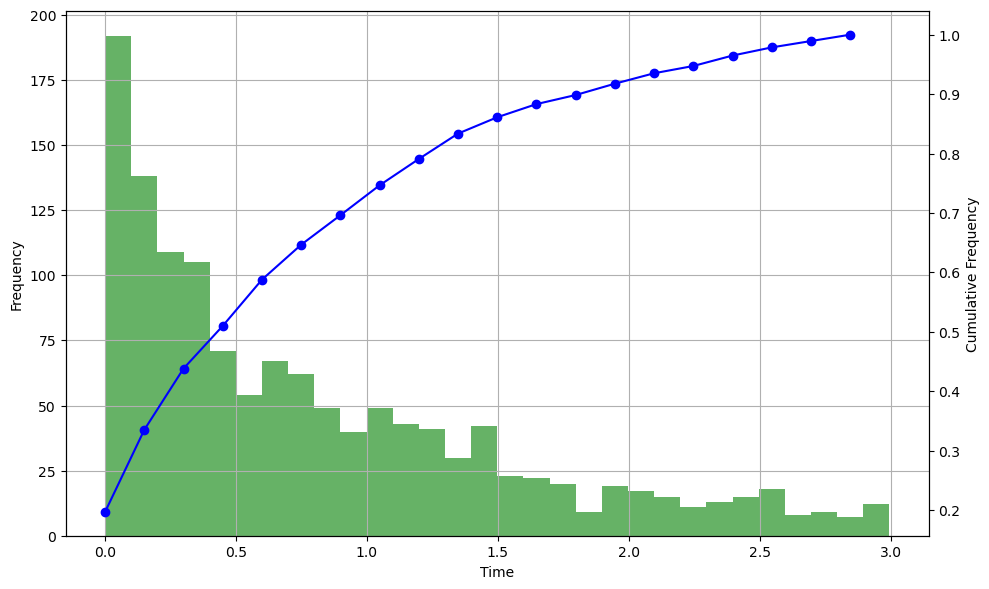

In [39]:
# Assuming the time data is in a column named 'time'
time_data = event_time_stats['min']

# Calculate histogram for the frequency distribution
hist, bins = np.histogram(time_data, bins=20, density=True)

# Calculate cumulative frequency
cumulative_freq = np.cumsum(hist * np.diff(bins))

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot histogram
ax1.hist(time_data, bins=30, alpha=0.6, color='g', label='Frequency Distribution')
ax1.set_xlabel('Time')
ax1.set_ylabel('Frequency')
ax1.grid(True)

# Plot cumulative frequency on the same plot
ax2 = ax1.twinx()
ax2.plot(bins[:-1], cumulative_freq, color='b', marker='o', linestyle='-', label='Cumulative Frequency')
ax2.set_ylabel('Cumulative Frequency')

# Set titles and show plot
fig.tight_layout()
plt.show()

# 1. Load data and split train and test samples

In [2]:
data_path = '../data/Risky_driving_behavior.csv' # Risky driving behavior data
oc_path = '../data/Crash_Index.csv' # Crash data
tf_path = '../data/Traffic_flow.csv' #Traffic flow data

data = pd.read_csv(data_path)
oc = pd.read_csv(oc_path)
tf_data = pd.read_csv(tf_path)

print(len(data))
def randomly_reduce_rows(df, reduction_ratio, random_seed=None):
    reduced_df = pd.DataFrame()
    unique_event_ids = df['event_id'].unique()
    for event_id in unique_event_ids:
        event_df = df[df['event_id'] == event_id]
        target_rows = ceil(len(event_df) * (1 - reduction_ratio))
        if target_rows < len(event_df):
            reduced_event_df = event_df.sample(n=target_rows, random_state=random_seed)
        else:
            reduced_event_df = event_df
        reduced_df = pd.concat([reduced_df, reduced_event_df], ignore_index=True)
    return reduced_df
data = randomly_reduce_rows(data, 0.2, 123+1)
print(len(data))

# transfer the 'event_id' into unique ID
all_event_id = np.array(data['event_id'].unique())
def inv_list(x):
    d = {}
    for i in range(len(x)):
        d[x[i]] = i
    return d
event_id_to_ind = inv_list(all_event_id)
data['event_id'] = data['event_id'].map(event_id_to_ind)
oc['event_id'] = oc['event_id'].map(event_id_to_ind)

# splot unique ID into train and test (7:3)
all_event_id = oc['event_id'].unique()
# np.random.seed(1018)
np.random.seed(124)
np.random.shuffle(all_event_id)
S = len(all_event_id)
bp = int(0.7*S)
train_event_ind = np.sort(all_event_id[:bp])
test_event_ind = np.sort(all_event_id[bp:])

8598
7390


# 2. Data process

## 2.1 Convert the traffic flow data into time series data for LSTM

In [3]:
n_timestemps = 5 #length of timestemps 
n_features = 18 #number of features in each time frame
n_obs = n_timestemps * n_features
df1=pd.DataFrame()
df2=pd.DataFrame()

ind_to_event_id = {v: k for k, v in event_id_to_ind.items()} 

decoded_train_event_ids = [ind_to_event_id[ind] for ind in train_event_ind] 
tf_train_data_temp = tf_data.copy()
tf_train_data_temp['event_id'] = pd.Categorical(tf_train_data_temp['event_id'], categories=decoded_train_event_ids, ordered=True) 
tf_train_data = tf_train_data_temp[tf_train_data_temp['event_id'].isin(decoded_train_event_ids)].sort_values('event_id').iloc[:, 1:]

decoded_test_event_ids = [ind_to_event_id[ind] for ind in test_event_ind] 
tf_test_data_temp = tf_data.copy()
tf_test_data_temp['event_id'] = pd.Categorical(tf_test_data_temp['event_id'], categories=decoded_test_event_ids, ordered=True) 
tf_test_data = tf_test_data_temp[tf_test_data_temp['event_id'].isin(decoded_test_event_ids)].sort_values('event_id').iloc[:, 1:]

train_y = tf_train_data['Crash']
train_X= tf_train_data.drop('Crash', axis=1)

for i in range(0,n_timestemps):
    new_column_order = [i + j*n_timestemps for j in range(0, 18)]
    df1 = pd.concat([df1, train_X.iloc[:, new_column_order]], axis=1)

df1 = np.array(df1)
train_X = df1.reshape((train_X.shape[0], n_timestemps, n_features))

test_y = tf_test_data['Crash']
test_X= tf_test_data.drop('Crash', axis=1)
for i in range(0,n_timestemps):
    new_column_order = [i + j*n_timestemps for j in range(0, 18)]
    df2 = pd.concat([df2, test_X.iloc[:, new_column_order]], axis=1)

df2 = np.array(df2)
test_X = df2.reshape((test_X.shape[0], n_timestemps, n_features))

test_y=pd.DataFrame(test_y)
test_y = pd.get_dummies(test_y['Crash'],  prefix='Category')

train_y=pd.DataFrame(train_y)
train_y = pd.get_dummies(train_y['Crash'], prefix='Category')

## 2.2 Convert the risky driving behavior data into non-aggregated data for Transformer

In [4]:
y = np.array(oc.sort_values(by='event_id')['Crash']).astype('float32')
N = data.event_id.max() + 1

data = data.sample(frac=1)
data = data.groupby('event_id').head(880)
N = data.event_id.max() + 1
varis = sorted(list(set(data.variable)))
V = len(varis)
def inv_list(l, start=0):
    d = {}
    for i in range(len(l)):
        d[l[i]] = i+start
    return d
var_to_ind = inv_list(varis, start=1)
data['vind'] = data.variable.map(var_to_ind)
data = data.sort_values(by=['event_id', 'vind', 'time'])

data = data.sort_values(by=['event_id']).reset_index(drop=True)
data = data.reset_index().rename(columns={'index':'obs_ind'})
data = data.merge(data.groupby('event_id').agg({'obs_ind':'min'}).reset_index().rename(columns={'obs_ind':'first_obs_ind'}), on='event_id')
data['obs_ind'] = data['obs_ind'] - data['first_obs_ind']

max_len = data.obs_ind.max()+1 # the maximum number of behaviors included in the samples
print ('max_len', max_len)

# Generate times_ip and values_ip matrices.
times_inp = np.zeros((N, max_len), dtype='float32')
space_inp = np.zeros((N, max_len), dtype='float32')
varis_inp = np.zeros((N, max_len), dtype='int32') 
speed_inp = np.zeros((N, max_len), dtype='float32')
acc_inp = np.zeros((N, max_len), dtype='float32')
duration_inp = np.zeros((N, max_len), dtype='float32')

for row in tqdm(data.itertuples()):
    event_id = row.event_id
    l = row.obs_ind
    times_inp[event_id, l] = row.time
    space_inp[event_id, l] = row.space
    varis_inp[event_id, l] = row.vind
    speed_inp[event_id, l] = row.speed
    acc_inp[event_id, l] = row.acc
    duration_inp[event_id, l] = row.duration
data.drop(columns=['obs_ind', 'first_obs_ind'], inplace=True)
# Generate 3 sets of inputs and outputs.
train_ip = [ip[train_event_ind] for ip in [ times_inp, space_inp, varis_inp, speed_inp, acc_inp, duration_inp]]
test_ip = [ip[test_event_ind] for ip in [ times_inp,space_inp, varis_inp, speed_inp, acc_inp, duration_inp]]
train_op = y[train_event_ind]
test_op = y[test_event_ind]

train_op = train_op[:, np.newaxis]
test_op = test_op[:, np.newaxis]

max_len 165


0it [00:00, ?it/s]

7390it [00:00, 370560.54it/s]


# 3. Model structure setting

## 3.1 Transformer model

In [5]:
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Layer
from tensorflow.python.ops import array_ops
from tensorflow import nn
from tensorflow.python.framework import smart_cond

# CVE function
class CVE(Layer):
    def __init__(self, hid_units, output_dim):
        self.hid_units = hid_units
        self.output_dim = output_dim
        super(CVE, self).__init__()
        
    def build(self, input_shape): 
        self.W1 = self.add_weight(name='CVE_W1',
                            shape=(1, self.hid_units),
                            initializer='glorot_uniform',
                            trainable=True)
        self.b1 = self.add_weight(name='CVE_b1',
                            shape=(self.hid_units,),
                            initializer='zeros',
                            trainable=True)
        self.W2 = self.add_weight(name='CVE_W2',
                            shape=(self.hid_units, self.output_dim),
                            initializer='glorot_uniform',
                            trainable=True)
        super(CVE, self).build(input_shape)
        
    def call(self, x):
        x = K.expand_dims(x, axis=-1)
        x = K.dot(K.tanh(K.bias_add(K.dot(x, self.W1), self.b1)), self.W2)
        return x
        
    def compute_output_shape(self, input_shape):
        return input_shape + (self.output_dim,)
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'hid_units': self.hid_units,
            'output_dim': self.output_dim
        })
        return config

# Attention layer
class Attention(Layer):
    
    def __init__(self, hid_dim):
        self.hid_dim = hid_dim
        super(Attention, self).__init__()

    def build(self, input_shape):
        d = input_shape.as_list()[-1]
        self.W = self.add_weight(shape=(d, self.hid_dim), name='Att_W',
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.hid_dim,), name='Att_b',
                                 initializer='zeros',
                                 trainable=True)
        self.u = self.add_weight(shape=(self.hid_dim,1), name='Att_u',
                                 initializer='glorot_uniform',
                                 trainable=True)
        super(Attention, self).build(input_shape)
        
    def call(self, x, mask, mask_value=-1e30):
        attn_weights = K.dot(K.tanh(K.bias_add(K.dot(x,self.W), self.b)), self.u)
        mask = K.expand_dims(mask, axis=-1)
        attn_weights = mask*attn_weights + (1-mask)*mask_value
        attn_weights = K.softmax(attn_weights, axis=-2)
        return attn_weights
        
    def compute_output_shape(self, input_shape):
        return input_shape[:-1] + (1,)
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'hid_dim': self.hid_dim
        })
        return config

# Overall Transformer model
class Transformer(Layer):
    
    def __init__(self, N=2, h=8, dk=None, dv=None, dff=None, dropout=0):
        self.N, self.h, self.dk, self.dv, self.dff, self.dropout = N, h, dk, dv, dff, dropout
        self.epsilon = K.epsilon() * K.epsilon()
        super(Transformer, self).__init__()

    def build(self, input_shape):
        d = input_shape.as_list()[-1]
        if self.dk==None:
            self.dk = d//self.h
        if self.dv==None:
            self.dv = d//self.h
        if self.dff==None:
            self.dff = 2*d
        self.Wq = self.add_weight(shape=(self.N, self.h, d, self.dk), name='Wq',
                                 initializer='glorot_uniform', trainable=True)
        self.Wk = self.add_weight(shape=(self.N, self.h, d, self.dk), name='Wk',
                                 initializer='glorot_uniform', trainable=True)
        self.Wv = self.add_weight(shape=(self.N, self.h, d, self.dv), name='Wv',
                                 initializer='glorot_uniform', trainable=True)
        self.Wo = self.add_weight(shape=(self.N, self.dv*self.h, d), name='Wo',
                                 initializer='glorot_uniform', trainable=True)
        self.W1 = self.add_weight(shape=(self.N, d, self.dff), name='W1',
                                 initializer='glorot_uniform', trainable=True)
        self.b1 = self.add_weight(shape=(self.N, self.dff), name='b1',
                                 initializer='zeros', trainable=True)
        self.W2 = self.add_weight(shape=(self.N, self.dff, d), name='W2',
                                 initializer='glorot_uniform', trainable=True)
        self.b2 = self.add_weight(shape=(self.N, d), name='b2',
                                 initializer='zeros', trainable=True)
        self.gamma = self.add_weight(shape=(2*self.N,), name='gamma',
                                 initializer='ones', trainable=True)
        self.beta = self.add_weight(shape=(2*self.N,), name='beta',
                                 initializer='zeros', trainable=True)
        super(Transformer, self).build(input_shape)
        
    def call(self, x, mask, mask_value=-1e-30):
        mask = K.expand_dims(mask, axis=-2)
        for i in range(self.N):
            # MHA
            mha_ops = []
            for j in range(self.h):
                q = K.dot(x, self.Wq[i,j,:,:])
                k = K.permute_dimensions(K.dot(x, self.Wk[i,j,:,:]), (0,2,1))
                v = K.dot(x, self.Wv[i,j,:,:])
                A = K.batch_dot(q,k)
                # Mask unobserved steps.
                A = mask*A + (1-mask)*mask_value
                # Mask for attention dropout.
                def dropped_A():
                    dp_mask = K.cast((K.random_uniform(shape=array_ops.shape(A))>=self.dropout), K.floatx())
                    return A*dp_mask + (1-dp_mask)*mask_value
                A = smart_cond.smart_cond(K.learning_phase(), dropped_A, lambda: array_ops.identity(A))
                A = K.softmax(A, axis=-1)
                mha_ops.append(K.batch_dot(A,v))
            conc = K.concatenate(mha_ops, axis=-1)
            proj = K.dot(conc, self.Wo[i,:,:])
            # Dropout.
            proj = smart_cond.smart_cond(K.learning_phase(), lambda: array_ops.identity(nn.dropout(proj, rate=self.dropout)),\
                                       lambda: array_ops.identity(proj))
            # Add & LN
            x = x+proj
            mean = K.mean(x, axis=-1, keepdims=True)
            variance = K.mean(K.square(x - mean), axis=-1, keepdims=True)
            std = K.sqrt(variance + self.epsilon)
            x = (x - mean) / std
            x = x*self.gamma[2*i] + self.beta[2*i]
            # FFN
            ffn_op = K.bias_add(K.dot(K.relu(K.bias_add(K.dot(x, self.W1[i,:,:]), self.b1[i,:])), 
                           self.W2[i,:,:]), self.b2[i,:,])
            # Dropout.
            ffn_op = smart_cond.smart_cond(K.learning_phase(), lambda: array_ops.identity(nn.dropout(ffn_op, rate=self.dropout)),\
                                       lambda: array_ops.identity(ffn_op))
            # Add & LN
            x = x+ffn_op
            mean = K.mean(x, axis=-1, keepdims=True)
            variance = K.mean(K.square(x - mean), axis=-1, keepdims=True)
            std = K.sqrt(variance + self.epsilon)
            x = (x - mean) / std
            x = x*self.gamma[2*i+1] + self.beta[2*i+1]            
        return x
        
    def compute_output_shape(self, input_shape):
        return input_shape
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'N': self.N,
            'h': self.h,
            'dk': self.dk,
            'dv': self.dv,
            'dff': self.dff,
            'dropout': self.dropout
        })
        return config

## 3.2 Transformer+LSTM model

In [6]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, LSTM, Dense, Add, Lambda,  Embedding
from tensorflow.keras.metrics import Recall, AUC
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import Callback

class EnsembleLayer(tf.keras.layers.Layer):
    def __init__(self, shape, name=None):
        super(EnsembleLayer, self).__init__(name=name)
        self.shape = shape
        
        w = 0.5
        self.alpha1 = self.add_weight(name='alpha1', shape=(),
                                       initializer=tf.keras.initializers.Constant(w),
                                       trainable=True)
        self.alpha2 = self.add_weight(name='alpha2', shape=(),
                                       initializer=tf.keras.initializers.Constant(w),
                                       trainable=True)

    def call(self, inputs):
        output1, output2 = inputs
        # output_new =  output1 * self.alpha1 + output2 * self.alpha2
        output_new = tf.concat([ output1 * self.alpha1 , output2 * self.alpha2], axis=-1)
        return output_new
    
    def get_alpha_values(self):
            return {"alpha1": self.alpha1.numpy(),
                    "alpha2": self.alpha2.numpy()}

class AlphaLogger(Callback):
    def __init__(self, cross_stitch_layer):
        super(AlphaLogger, self).__init__()
        self.cross_stitch_layer = cross_stitch_layer
        self.alpha1_values = []
        self.alpha2_values = []

    def on_epoch_end(self, epoch, logs=None):
        alpha_values = self.cross_stitch_layer.get_alpha_values()
        self.alpha1_values.append(alpha_values["alpha1"])
        self.alpha2_values.append(alpha_values["alpha2"])
        print(f"Epoch {epoch + 1}: alpha1 = {alpha_values['alpha1']}, alpha2 = {alpha_values['alpha2']}")

lstm_input_shape = (n_timestemps, n_features) 
your_epochs = 100
d, N, he, dropout = 50, 2, 4, 0.2
lstm_units = d

# LSTM model
lstm_input = Input(shape=lstm_input_shape)
lstm_new = LSTM(lstm_units, return_sequences=True)(lstm_input)
lstm_out = LSTM(lstm_units, return_sequences=False)(lstm_new)
lstm_final =  Dense(1, activation='sigmoid')(lstm_out)

# Transformer model
times_input = Input(shape=(max_len,))
space_input = Input(shape=(max_len,))
varis_input = Input(shape=(max_len,))
speed_input = Input(shape=(max_len,))
acc_input = Input(shape=(max_len,))
duration_input = Input(shape=(max_len,))

cve_units = int(np.sqrt(d))
times_emb = CVE(cve_units, d)(times_input)
space_emb = CVE(cve_units, d)(space_input)
varis_emb = Embedding(V+1, d)(varis_input)
speed_emb = CVE(cve_units, d)(speed_input)
acc_emb = CVE(cve_units, d)(acc_input)
duration_emb = CVE(cve_units, d)(duration_input)

comb_emb = Add(name='comb_emb')([times_emb, space_emb, varis_emb, speed_emb, acc_emb, duration_emb])
mask = Lambda(lambda x: K.clip(x, 0, 1))(varis_input)  # b, L
cont_emb = Transformer(N, he, dk=None, dv=None, dff=None, dropout=dropout)(comb_emb, mask=mask)
attn_weights = Attention(2*d)(cont_emb, mask=mask)
transformer_out = Lambda(lambda x:K.sum(x[0]*x[1], axis=-2))([cont_emb, attn_weights])
transformer_final =  Dense(1, activation='sigmoid')(transformer_out)

Ensemble_layer = EnsembleLayer(shape=d)
concatenated = Ensemble_layer([lstm_out, transformer_out])
final_out = Dense(1, activation='sigmoid', use_bias=True, bias_initializer='zeros')(concatenated)

## 3.3 Model loss & data input setting

In [7]:
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.metrics import roc_curve, accuracy_score, recall_score

# Define model loss
class_weights = compute_class_weight(class_weight='balanced', classes=[0, 1], y=train_op.ravel())
class_weights[0] = 1
class_weights[1] = 5
def mortality_loss(y_true, y_pred):
    sample_weights = (1-y_true)*class_weights[0] + y_true*class_weights[1]
    bce = K.binary_crossentropy(y_true, y_pred)
    return K.mean(sample_weights*bce, axis=-1)

# data_ generator function
def data_generator(train_X, train_ip, train_op, batch_size):
    num_samples = len(train_X)
    
    indices = np.arange(num_samples)
    np.random.shuffle(indices)
    
    while True:
        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            batch_indices = indices[start_idx:end_idx]
            
            batch_train_X = train_X[batch_indices]
            batch_train_ip = [arr[batch_indices] for arr in train_ip]
            batch_train_op = train_op[batch_indices].reshape(-1, 1)

            input_combined = [batch_train_X] + batch_train_ip

            input_lstm = [batch_train_X]

            input_transformer = batch_train_ip
            
            yield input_combined, batch_train_op, input_lstm, batch_train_op, input_transformer, batch_train_op

        np.random.shuffle(indices)

# Define model evaluation metrics
metrics = ['accuracy', Recall(name='recall'), AUC(name='auc')]
def far(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return 1 - true_negatives / (possible_negatives + K.epsilon())
metrics.append(far)

def evaluate_model_at_specific_far(model, inputs, y_test, far_target=0.2):
    y_pred_prob = model.predict(inputs).ravel()
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    closest_far_idx = np.argmin(np.abs(fpr - far_target))
    threshold = thresholds[closest_far_idx]
    y_pred = (y_pred_prob >= threshold).astype(int)
    acc = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    far = fpr[closest_far_idx]

    return acc, recall, far, threshold

def plot_metrics(history):
    metrics = ['loss', 'accuracy', 'recall', 'auc', 'far']
    for metric in metrics:
        plt.figure()
        plt.plot(history.history[metric], label='Train ' + metric)
        plt.plot(history.history['val_' + metric], label='Validation ' + metric)
        plt.title('Train vs Validation ' + metric)
        plt.legend()
        plt.show()

def plot_confusion_matrix(confusion, title, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(5, 4))
    
    sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title(title)

def plot_all_confusion_matrices(matrices, titles):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
    
    for ax, matrix, title in zip(axes.ravel(), matrices, titles):
        plot_confusion_matrix(matrix, title, ax=ax)
        
    plt.tight_layout()
    plt.show()

# 4. Model training

## 4.1 Transformer+LSTM Model training (Both risky driving behavior and traffic flow data)

Epoch 1/100
14/14 [==============================] - 10s 142ms/step - loss: 1.2444 - accuracy: 0.3583 - recall: 0.6949 - auc: 0.4602 - far: 0.7210 - val_loss: 1.2705 - val_accuracy: 0.2344 - val_recall: 0.9512 - val_auc: 0.5085 - val_far: 0.9598
Epoch 2/100
14/14 [==============================] - 0s 32ms/step - loss: 1.2422 - accuracy: 0.2230 - recall: 0.9885 - auc: 0.5600 - far: 0.9716 - val_loss: 1.2435 - val_accuracy: 0.2214 - val_recall: 1.0000 - val_auc: 0.6002 - val_far: 0.9843
Epoch 3/100
14/14 [==============================] - 0s 34ms/step - loss: 1.2194 - accuracy: 0.2113 - recall: 1.0000 - auc: 0.5923 - far: 0.9828 - val_loss: 1.2432 - val_accuracy: 0.2292 - val_recall: 0.9634 - val_auc: 0.6741 - val_far: 0.9711
Epoch 4/100
14/14 [==============================] - 0s 33ms/step - loss: 1.1983 - accuracy: 0.2300 - recall: 0.9693 - auc: 0.6181 - far: 0.9477 - val_loss: 1.2189 - val_accuracy: 0.2839 - val_recall: 0.9367 - val_auc: 0.6851 - val_far: 0.8854
Epoch 5/100
14/14 [===

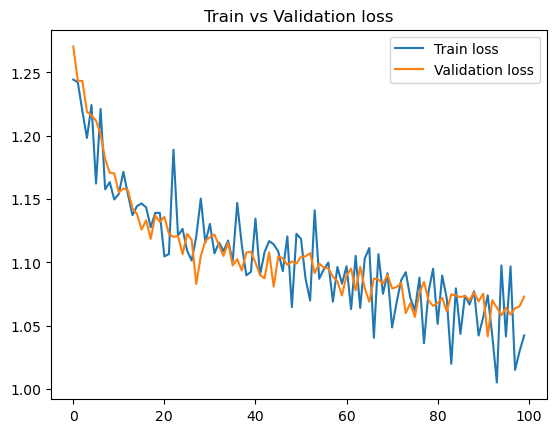

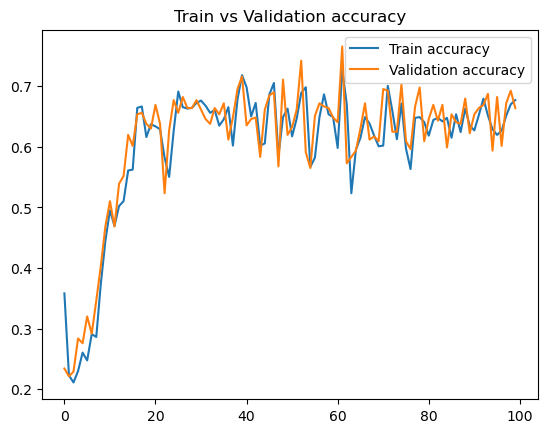

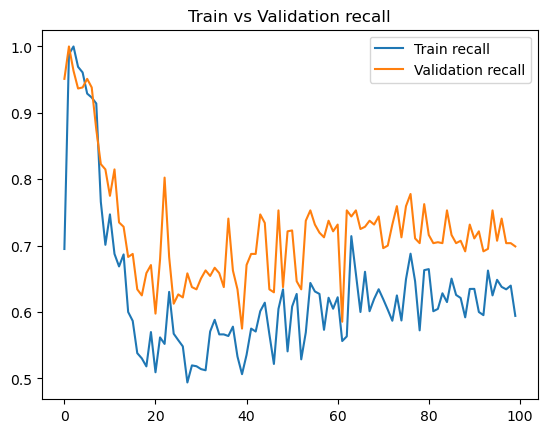

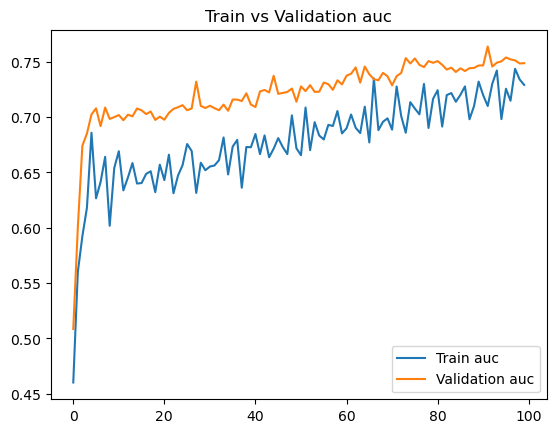

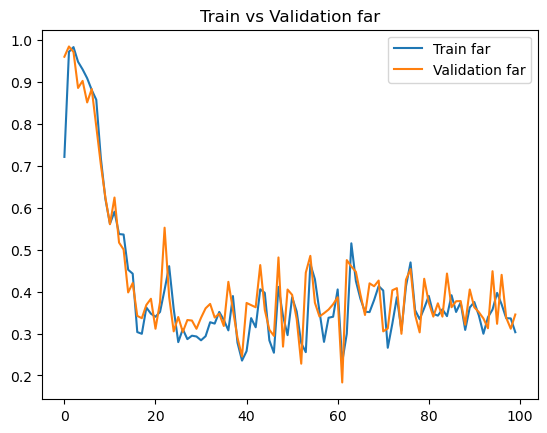

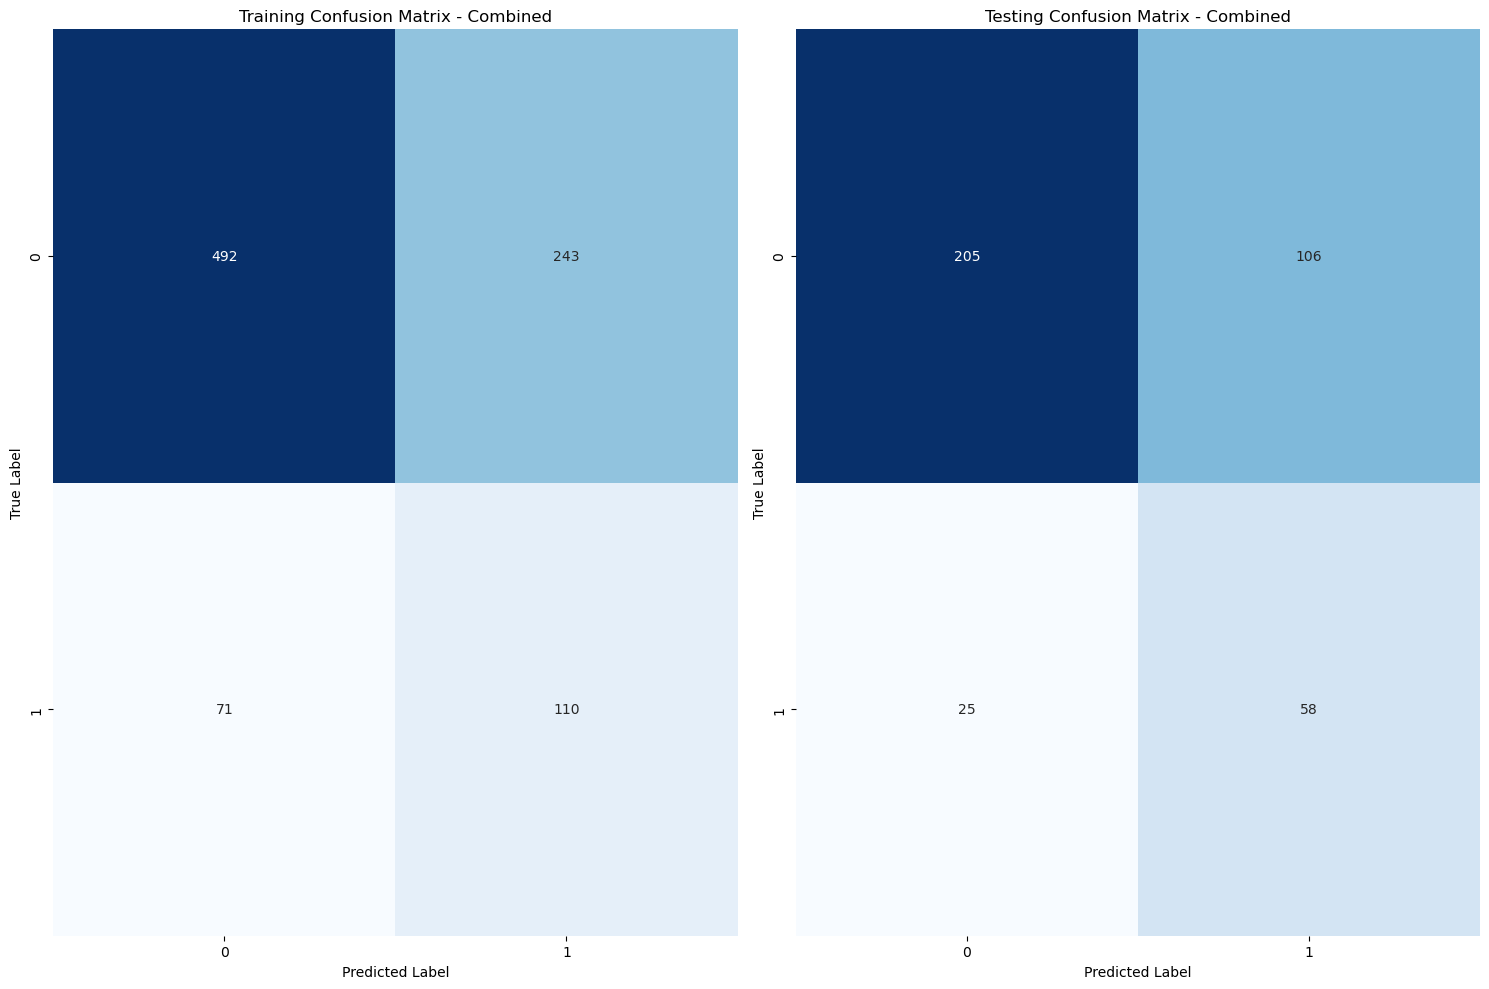

13/13 [==============================] - 0s 7ms/step
train:
cutoff: 0.5188306570053101
accuracy: 0.7107, recall: 0.5580, FAR: 0.2517

test:
cutoff: 0.5170398950576782
accuracy: 0.7208, recall: 0.6627, FAR: 0.2637


In [8]:
from tensorflow.keras.models import Model

# training hyperparameters
batch_size, lr= 64, 4.e-5

model = Model(inputs=[lstm_input, times_input, space_input, varis_input, speed_input, acc_input, duration_input], outputs=final_out)

model.compile(optimizer=Adam(learning_rate=lr), 
              loss=mortality_loss,
              metrics=metrics)

train_gen_combined = ((inputs_combined,y) for inputs_combined, y, _, _, _, _ in data_generator(train_X, train_ip, train_op, batch_size))
val_gen_combined = ((inputs_combined,y) for inputs_combined, y, _, _, _, _ in data_generator(test_X, test_ip, test_op, batch_size))

# Create the alpha logger callback
alpha_logger = AlphaLogger(Ensemble_layer)

# Model training
history_combined = model.fit(
    train_gen_combined,
    steps_per_epoch=len(train_X) // batch_size,
    epochs=your_epochs,
    validation_data=val_gen_combined,
    validation_steps=len(test_X) // batch_size,
    callbacks=[alpha_logger]
)

train_predictions = model.predict([train_X] + train_ip)
train_predictions = (train_predictions > 0.5).astype(int) 

test_predictions = model.predict([test_X] + test_ip)
test_predictions = (test_predictions > 0.5).astype(int) 

cm_list = [
    confusion_matrix(train_op, train_predictions),
    confusion_matrix(test_op, test_predictions),
]

title_list = [
    "Training Confusion Matrix - Combined",
    "Testing Confusion Matrix - Combined",
]

plot_metrics(history_combined)
plot_all_confusion_matrices(cm_list, title_list)

acc_train, recall_train, far_train, threshold_train = evaluate_model_at_specific_far(model, [train_X] + train_ip, train_op, far_target=0.25)
acc_test, recall_test, far_test, threshold_test = evaluate_model_at_specific_far(model, [test_X] + test_ip, test_op, far_target=0.25)

print("train:")
print(f"cutoff: {threshold_train}")
print(f"accuracy: {acc_train:.4f}, recall: {recall_train:.4f}, FAR: {far_train:.4f}")

print("\ntest:")
print(f"cutoff: {threshold_test}")
print(f"accuracy: {acc_test:.4f}, recall: {recall_test:.4f}, FAR: {far_test:.4f}")

## 4.2 Observation of weights of LSTM (traffic flow features) and Transformer (risky driving behavior features)

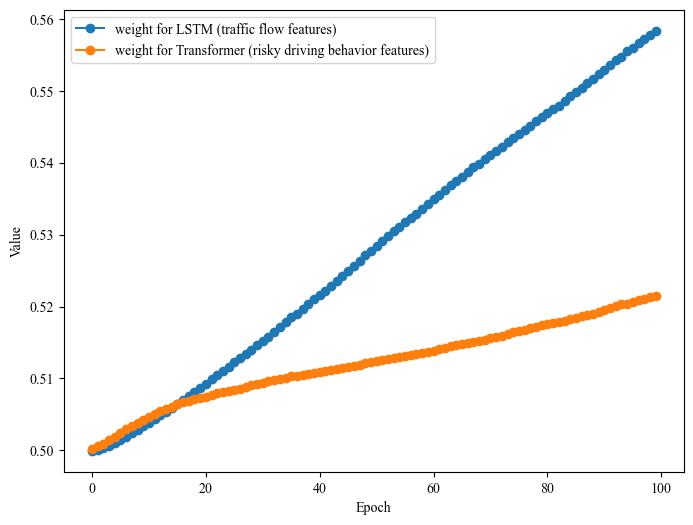

In [10]:
import matplotlib.pyplot as plt

# Create a larger figure
plt.figure(figsize=(8, 6))  # Width, Height in inches

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

plt.plot(alpha_logger.alpha1_values, marker='o', linestyle='-', label='weight for LSTM (traffic flow features)')
plt.plot(alpha_logger.alpha2_values, marker='o', linestyle='-', label='weight for Transformer (risky driving behavior features)')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

## 4.2 LSTM Model training (Traffic flow data)

Epoch 1/100
28/28 [==============================] - 4s 44ms/step - loss: 0.8554 - accuracy: 0.7958 - recall: 0.6809 - auc: 0.8088 - far: 0.1813 - val_loss: 1.1204 - val_accuracy: 0.6562 - val_recall: 0.6463 - val_auc: 0.7232 - val_far: 0.3492
Epoch 2/100
28/28 [==============================] - 0s 12ms/step - loss: 0.8825 - accuracy: 0.6889 - recall: 0.8056 - auc: 0.8441 - far: 0.3412 - val_loss: 1.1568 - val_accuracy: 0.7161 - val_recall: 0.6296 - val_auc: 0.7109 - val_far: 0.2559
Epoch 3/100
28/28 [==============================] - 0s 11ms/step - loss: 0.8432 - accuracy: 0.7783 - recall: 0.7644 - auc: 0.8573 - far: 0.2173 - val_loss: 1.1374 - val_accuracy: 0.6458 - val_recall: 0.6375 - val_auc: 0.7115 - val_far: 0.3472
Epoch 4/100
28/28 [==============================] - 0s 12ms/step - loss: 0.8548 - accuracy: 0.7161 - recall: 0.7849 - auc: 0.8457 - far: 0.3002 - val_loss: 1.1162 - val_accuracy: 0.6953 - val_recall: 0.6543 - val_auc: 0.7315 - val_far: 0.2929
Epoch 5/100
28/28 [=====

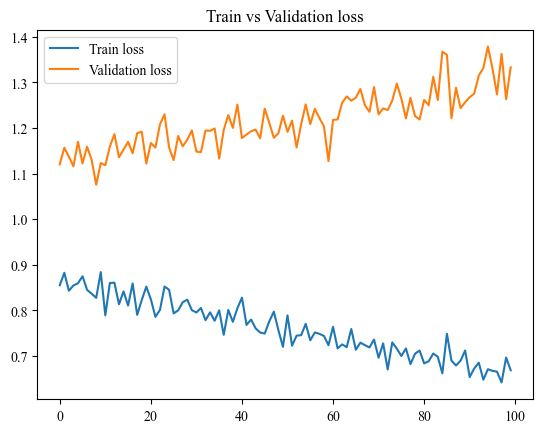

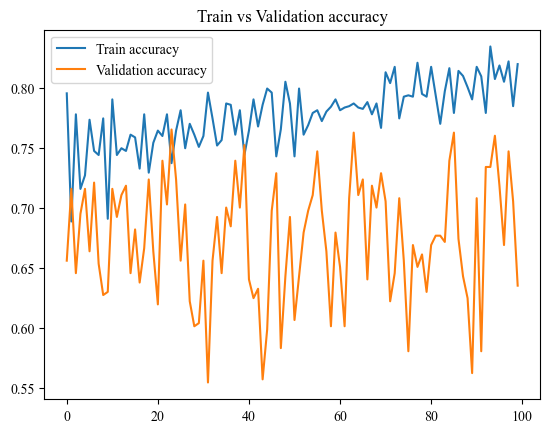

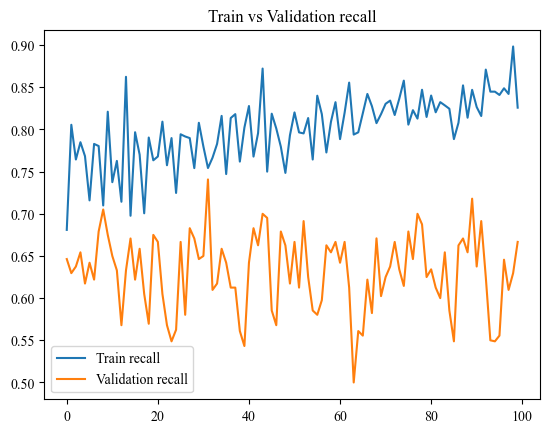

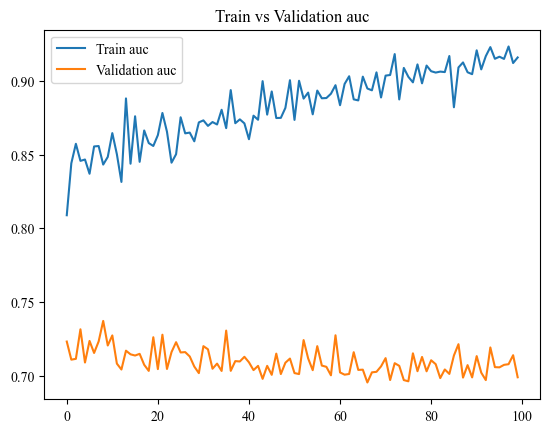

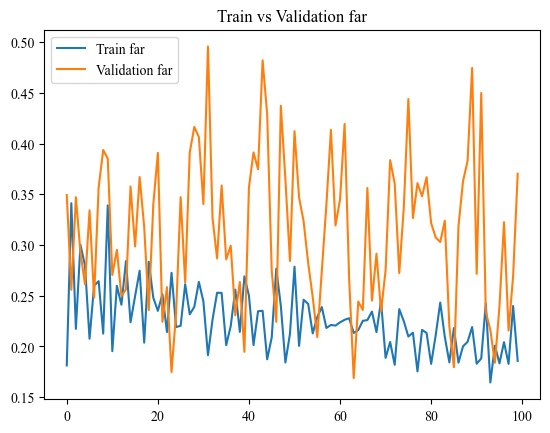

In [12]:
batch_size, lr= 32, 1.e-4
model_lstm = Model(inputs=lstm_input, outputs=lstm_final)

model_lstm.compile(optimizer=Adam(learning_rate=lr), 
                   loss=mortality_loss,
                   metrics=metrics)

train_gen_lstm = ((inputs_lstm,y) for _, _, inputs_lstm, y, _, _ in data_generator(train_X, train_ip, train_op, batch_size))
val_gen_lstm = ((inputs_lstm,y) for _, _, inputs_lstm, y, _, _ in data_generator(test_X, test_ip, test_op, batch_size))

history_lstm = model_lstm.fit(
    train_gen_lstm,
    steps_per_epoch=len(train_X) // batch_size,
    epochs=your_epochs,
    validation_data=val_gen_lstm,
    validation_steps=len(test_X) // batch_size,
)

train_predictions_lstm = model_lstm.predict([train_X])
train_predictions_lstm = (train_predictions_lstm > 0.5).astype(int) 

test_predictions_lstm = model_lstm.predict([test_X])
test_predictions_lstm = (test_predictions_lstm > 0.5).astype(int) 

plot_metrics(history_lstm)

## 4.3 Transformer model training (Risky driving behavior data)

Epoch 1/100
28/28 [==============================] - 5s 55ms/step - loss: 1.2540 - accuracy: 0.4877 - recall: 0.6139 - auc: 0.5999 - far: 0.5413 - val_loss: 1.2116 - val_accuracy: 0.3021 - val_recall: 0.8902 - val_auc: 0.6352 - val_far: 0.8614
Epoch 2/100
28/28 [==============================] - 1s 25ms/step - loss: 1.1739 - accuracy: 0.5656 - recall: 0.6012 - auc: 0.6233 - far: 0.4449 - val_loss: 1.1420 - val_accuracy: 0.4401 - val_recall: 0.6962 - val_auc: 0.6640 - val_far: 0.6261
Epoch 3/100
28/28 [==============================] - 1s 25ms/step - loss: 1.1572 - accuracy: 0.5509 - recall: 0.6629 - auc: 0.6442 - far: 0.4760 - val_loss: 1.1236 - val_accuracy: 0.5703 - val_recall: 0.6707 - val_auc: 0.6844 - val_far: 0.4575
Epoch 4/100
28/28 [==============================] - 1s 24ms/step - loss: 1.1325 - accuracy: 0.6222 - recall: 0.6517 - auc: 0.6731 - far: 0.3878 - val_loss: 1.1025 - val_accuracy: 0.5885 - val_recall: 0.6456 - val_auc: 0.6825 - val_far: 0.4251
Epoch 5/100
28/28 [=====

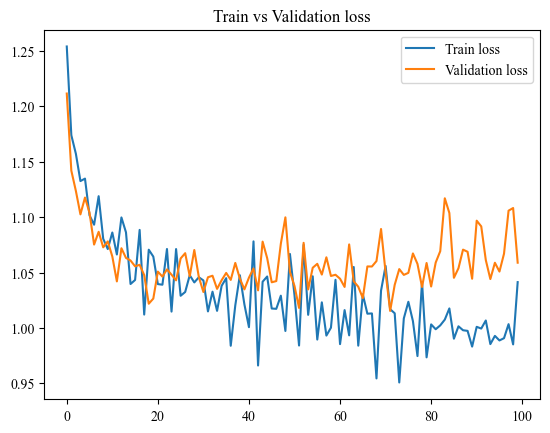

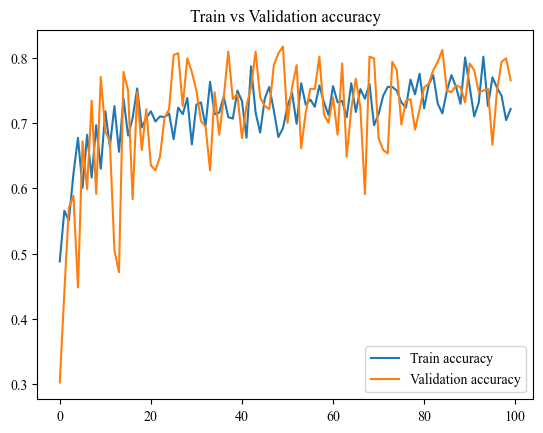

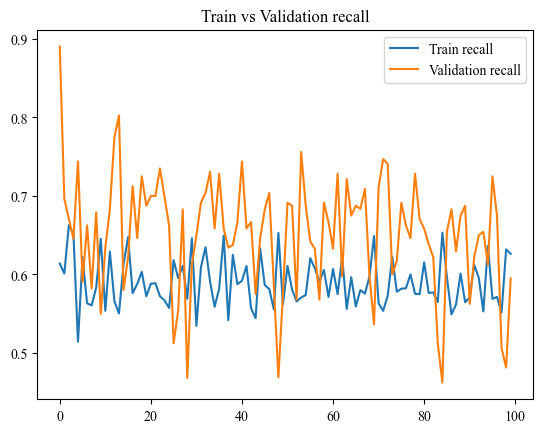

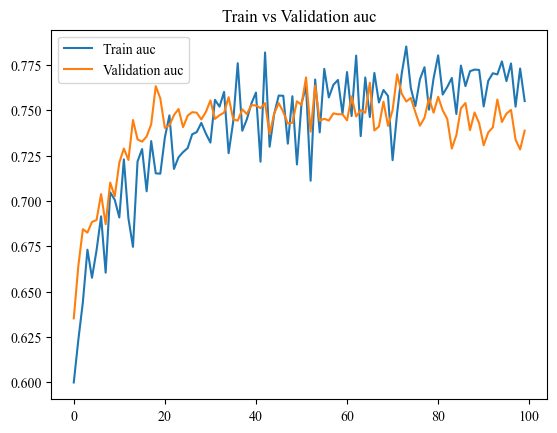

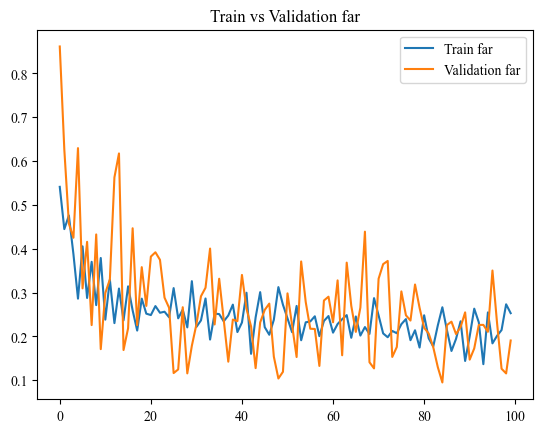

In [13]:
batch_size, lr= 32, 5.e-5

model_transformer = Model(inputs=[times_input, space_input, varis_input, speed_input, acc_input, duration_input], outputs=transformer_final)
model_transformer.compile(optimizer=Adam(learning_rate=lr), 
                          loss=mortality_loss,
                          metrics=metrics)

train_gen_transformer = ((inputs_transformer,y) for _, _, _, _, inputs_transformer, y in data_generator(train_X, train_ip, train_op, batch_size))
val_gen_transformer = ((inputs_transformer,y) for _, _, _, _, inputs_transformer, y in data_generator(test_X, test_ip, test_op, batch_size))

history_transformer = model_transformer.fit(
    train_gen_transformer,
    steps_per_epoch=len(train_X) // batch_size,
    epochs=your_epochs,
    validation_data=val_gen_transformer,
    validation_steps=len(test_X) // batch_size,
)

train_predictions_transfermor = model_transformer.predict(train_ip)
train_predictions_transfermor = (train_predictions_transfermor > 0.5).astype(int)  

test_predictions_transfermor = model_transformer.predict(test_ip)
test_predictions_transfermor = (test_predictions_transfermor > 0.5).astype(int) 

plot_metrics(history_transformer)